In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 读取数据
df = pd.read_csv('C:\\Users\\endorphin\\Desktop\\神经网络\\作业2\\AirQualityUCI.csv')
df.describe().T.style.background_gradient(axis=0)


,count,mean,std,min,25%,50%,75%,max
CO(GT),9357.000000,-34.207524,77.657170,-200.000000,0.600000,1.500000,2.600000,11.900000
PT08.S1(CO),9357.000000,1048.990061,329.832710,-200.000000,921.000000,1053.000000,1221.000000,2040.000000
NMHC(GT),9357.000000,-159.090093,139.789093,-200.000000,-200.000000,-200.000000,-200.000000,1189.000000
C6H6(GT),9357.000000,1.865683,41.380206,-200.000000,4.000000,7.900000,13.600000,63.700000
PT08.S2(NMHC),9357.000000,894.595276,342.333252,-200.000000,711.000000,895.000000,1105.000000,2214.000000
NOx(GT),9357.000000,168.616971,257.433866,-200.000000,50.000000,141.000000,284.000000,1479.000000
PT08.S3(NOx),9357.000000,794.990168,321.993552,-200.000000,637.000000,794.000000,960.000000,2683.000000
NO2(GT),9357.000000,58.148873,126.940455,-200.000000,53.000000,96.000000,133.000000,340.000000
PT08.S4(NO2),9357.000000,1391.479641,467.210125,-200.000000,1185.000000,1446.000000,1662.000000,2775.000000
PT08.S5(O3),9357.000000,975.072032,456.938184,-200.000000,700.000000,942.000000,1255.000000,2523.000000


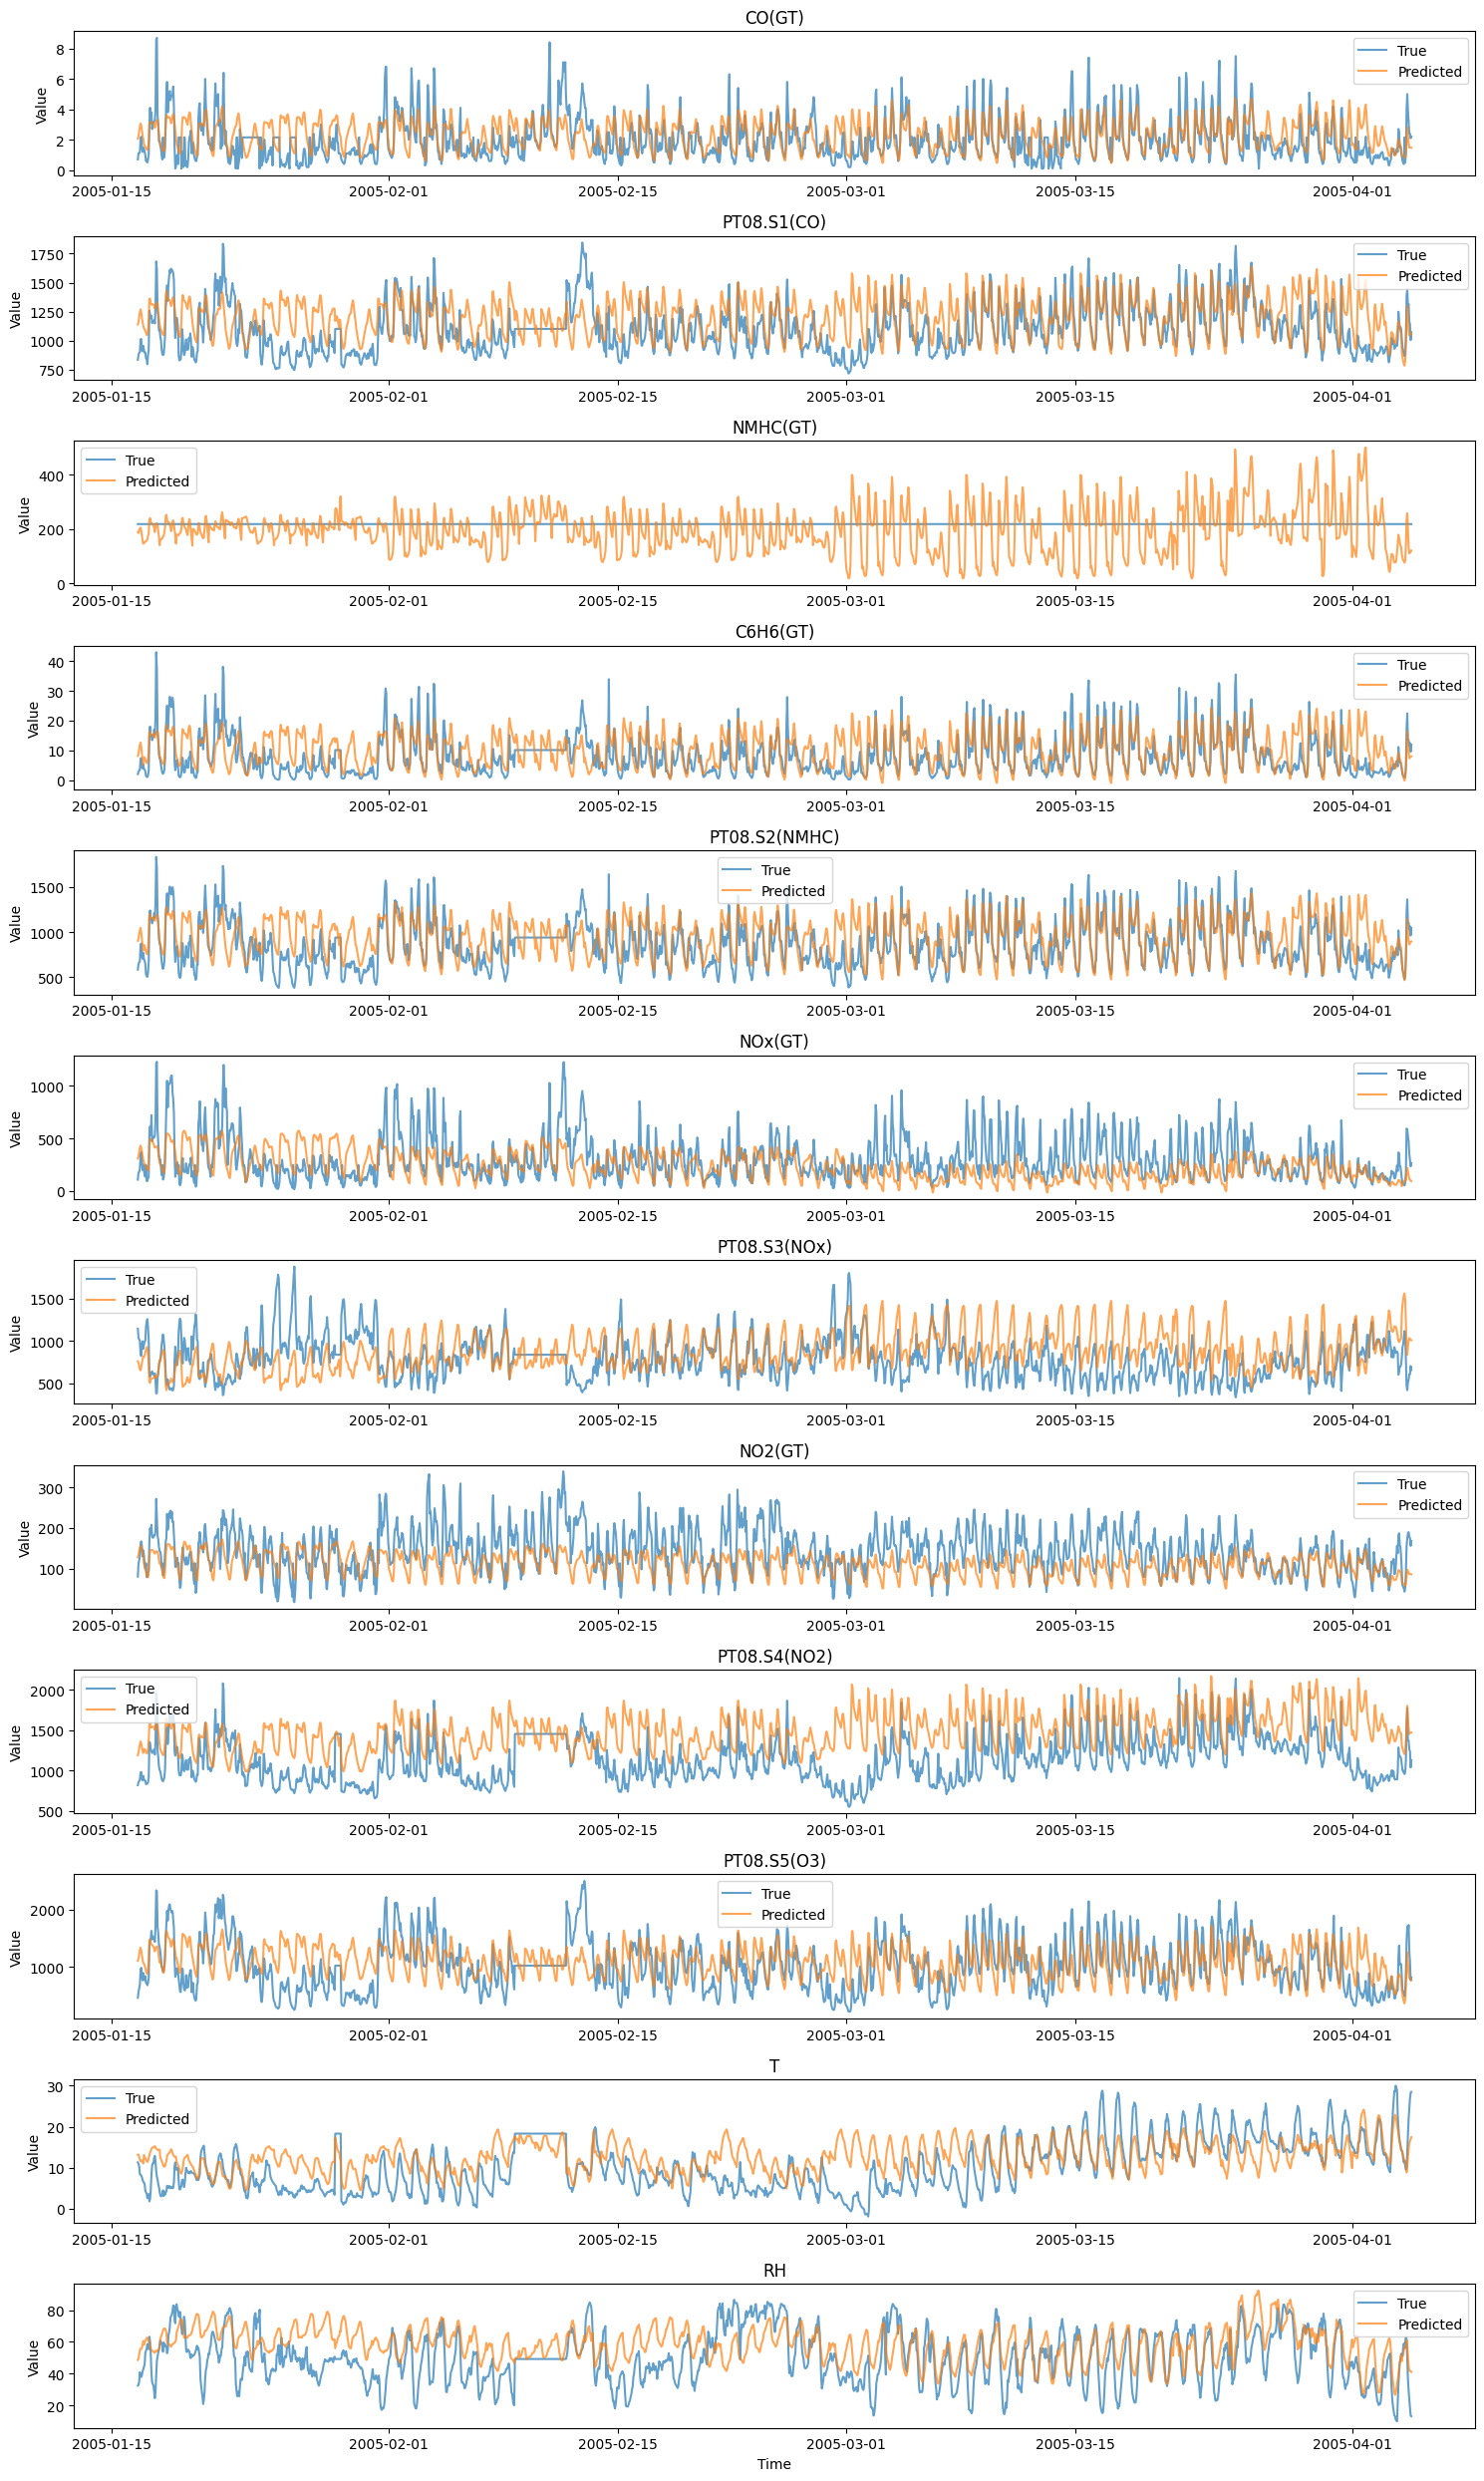

In [ ]:
# 数据预处理
def preprocess_data(df):
    df['datetime'] = pd.to_datetime(
        df['Date'].astype(str) + ' ' + df['Time'].astype(str),
        format='%d/%m/%Y %H.%M.%S'
    )
    df = df.sort_values('datetime')
    
    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
    df[numeric_cols] = df[numeric_cols].replace(-200, np.nan)
    
    cols_to_exclude = ['hour', 'day_of_week', 'month']
    valid_numeric_cols = [col for col in numeric_cols if col not in cols_to_exclude]
    col_means = df[valid_numeric_cols].mean()
    df[valid_numeric_cols] = df[valid_numeric_cols].fillna(col_means)
    
    df['hour'] = df['datetime'].dt.hour
    df['day_of_week'] = df['datetime'].dt.dayofweek
    df['month'] = df['datetime'].dt.month
    
    target_columns = ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)',
                      'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
                      'PT08.S5(O3)', 'T', 'RH']
    
    final_numeric_cols = df.select_dtypes(include=np.number).columns
    X = df[final_numeric_cols].drop(target_columns, axis=1)
    y = df[target_columns]
    
    return X, y, df

X, y, df = preprocess_data(df)

# 时间顺序分割
train_size = int(0.8 * len(X))
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train_orig, y_test_orig = y.iloc[:train_size], y.iloc[train_size:]

# 标准化
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train_orig)
y_test = scaler_y.transform(y_test_orig)

# 转换为张量
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# 模型定义
class MultiOutputModel(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_size)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

model = MultiOutputModel(
    input_size=X_train.shape[1],
    output_size=y_train.shape[1]
)

# 训练设置
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)

# 训练循环
for epoch in range(100):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

# 预测
model.eval()
with torch.no_grad():
    preds = model(X_test_tensor)
    y_pred = scaler_y.inverse_transform(preds.numpy())

# 转换为 DataFrame
predicted_df = pd.DataFrame(y_pred, columns=y.columns)

# 时间序列绘图
time_axis = df['datetime'].iloc[train_size:].reset_index(drop=True)
true_df = y_test_orig.reset_index(drop=True)

features_to_plot = ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)',
                      'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
                      'PT08.S5(O3)', 'T', 'RH']

plt.figure(figsize=(15, 25))
for i, feature in enumerate(features_to_plot):
    plt.subplot(len(features_to_plot), 1, i + 1)
    plt.plot(time_axis, true_df[feature], label='True', alpha=0.7)
    plt.plot(time_axis, predicted_df[feature], label='Predicted', alpha=0.7)
    plt.title(feature)
    plt.ylabel("Value")
    plt.legend()

plt.xlabel("Time")
plt.tight_layout()
plt.show()
